In [1]:
#standard imports
import detprocess as dp
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import math
import qetpy as qp
from pytesdaq.processing import ContinuousData


from pytesdaq.io.hdf5 import H5Reader, getrandevents

from scipy import stats, optimize

from matplotlib import rc
rc('text', usetex=False)
rc('font', family="sans-serif")
rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

h5_reader = H5Reader()

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
run = '_19/'
series = '_D20220801_T193149'
version = 'ba'
suffix = '/sdata2/runs/run19/raw/'
suffix_analysis = '/data/users/da_real_maggie_reed/analysis/run'+run
#trigger_ba_I2_D20220809_T182401
trigger_path = suffix + 'trigger_' + version + '_I2_D20220809_T182401'
yaml_path = suffix_analysis + 'data/process_run19_Ba.yaml'
save_path = '/sdata1/runs/run19/processed/' + 'deptprocess_'+ version + '_I2' + series
if not Path(save_path).is_dir():
    raise OSError(f"Please create {save_path} for saving processed files.")
series = [Path(s).parts[-1] for s in sorted(glob(f"{trigger_path}*"))]

In [4]:
#create a psd for this set since one has not been made yet
filter_file = trigger_path+'/I2_D20220809_T182401_filter.pickle'
import pickle
from pprint import pprint
with open(filter_file,'rb') as f:
    myfilter = pickle.load(f)
pprint(myfilter)

{'f': [array([   0.,   50.,  100., ..., -150., -100.,  -50.])],
 'f_fold': [array([0.0000e+00, 5.0000e+01, 1.0000e+02, ..., 6.2490e+05, 6.2495e+05,
       6.2500e+05])],
 'psd': [array([3.24868832e-14, 3.86829886e-21, 1.19227766e-21, ...,
       7.47805212e-22, 1.19227766e-21, 3.86829886e-21])],
 'psd_fold': [array([3.24868832e-14, 7.73659773e-21, 2.38455532e-21, ...,
       1.17626898e-21, 1.62429898e-21, 9.51601438e-22])],
 'template': [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.09351138e-14, 3.08571426e-14, 3.07793679e-14])],
 'trigger_channels': 'CPDv21Ge'}


In [10]:
psdtxt = myfilter['psd']
np.savetxt("psd_Ba_12hr_I2_D20220801_T193149", psdtxt)

In [12]:
#process over our data
#for ii, file in enumerate(sorted(glob(f"{trigger_path}/*.hdf5"))):
    df = dp.process_data(
        file,
        yaml_path,
        savepath=save_path, # pass None if you don't want to save the file (for debugging)
        #nevents=10, # process only the first 10 events (for debugging)
        #external_file=None, # set to the path to an external file that contains different features than the default (see the README for more info)
    )
    print(ii)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
#loads all the features we got from the hdf5 made by dp
#returns a dataframe
#files are already created and ready to go from a prior build
df = dp.io.load_features(save_path)


In [91]:
#template = np.loadtxt(suffix_analysis+'template_nos_12hr_I2_D20220909_T173605.txt')

In [4]:
#setting triggers for both frames and the merged frames
ctrigger = df.triggertype == 1
crandoms = df.triggertype == 0

fs = 1.25e6
tracelength = 20e-3
#f_fold, psd_fold = qp.foldpsd(psd, fs)

from scipy import constants

#defining calibrated ofamp from run 10 calculated calibration coeff
m_run10 = 8.045875997742481e-08
calibratedofamp_uncon = df.ofamp_unconstrained_CPDv21Ge/m_run10
calibratedofamp_nodelay = df.ofamp_nodelay_CPDv21Ge/m_run10
calibratedofamp_constrained= df.ofamp_constrained_CPDv21Ge/m_run10

#defining calibrated energy (integrated) from collection efficiency of 16%
calibratedenergy = -((df.energyabsorbed_CPDv21Ge/constants.e)/161)


# Chi2 good time cuts

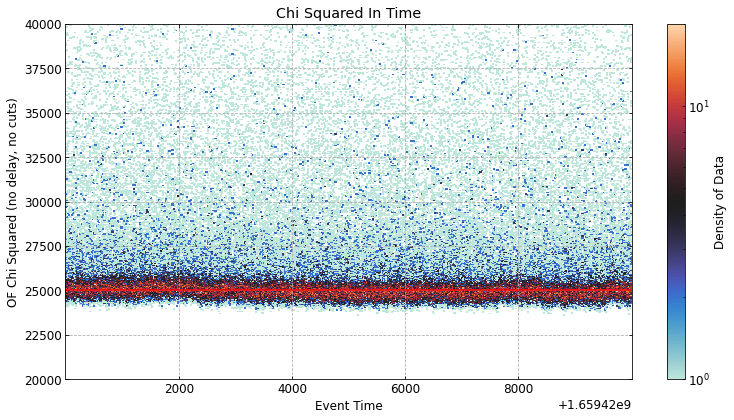

In [8]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.ofchi2_nodelay_CPDv21Ge,
    cut=ctrigger&cgoodtime,
    ylims=[0.2e5, 4e4],
  #  xlims=[0, 1.2],
)

#number of dof per trace (chi2 mean)
ax.axhline((fs*tracelength),c='r')
ax.set_xlabel('Event Time')
ax.set_ylabel('OF Chi Squared (no delay, no cuts)')
ax.set_title('Chi Squared In Time')
fig.tight_layout()

'''
fig.savefig(
'/data/users/da_real_maggie_reed/analysis/run_20/figs/run20_goodtime_postc.png',
dpi=500,
facecolor='none',
)
#''';

In [7]:
#defining our times

cgoodtime = (dp.inrange(df.eventtime,20000+1.6594e9,30000+1.6594e9))

#for plotting time in a way that makes sense and getting total time for rates etc
plot_eventtime = df.eventtime - df.eventtime[0]
tot_runtime = df.eventtime[ctrigger].iloc[-1]-df.eventtime[ctrigger].iloc[0]


In [8]:
#events_upper = sum(ctemp_up[ctrigger&cgood_time])/tot_time

#print('the rate of events in the lower distribution is:',events_lower,'\n')


# Baseline cut

In [11]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df.eventtime[ctrigger].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime/binsize

cbaseline_list=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list[i]=dp.inrange(df.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime)
    cut_value=np.percentile(df.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list[-1]=dp.inrange(df.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [12]:
#more rigorous baseline cut
cbaseline=cbaseline_list[0]
for i in range(len(cbaseline_list)):
    cbaseline=cbaseline|cbaseline_list[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


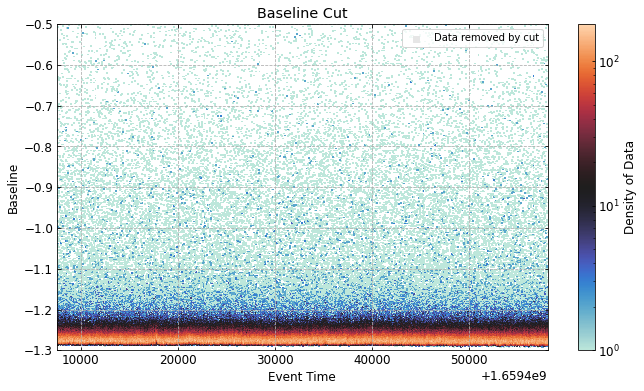

In [13]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.baseline_CPDv21Ge*1e6,
    #cut=cbaseline,
    ylims=(-1.3,-0.5),
    plot_cut_data = True
    )
ax.set_xlabel('Event Time')
ax.set_ylabel('Baseline')
ax.set_title('Baseline Cut')
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/run20_baseline_postc.png',dpi=500,
    facecolor='none',
)
#''';

## Distribution 

1424598.832968636 1/V
0.0041556985304364085


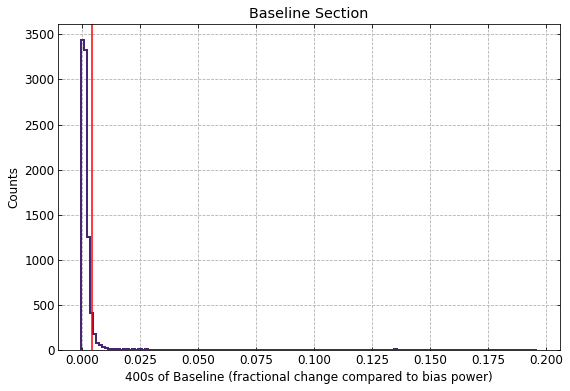

In [24]:
# checking baseline gaussian distribution for tail location to confirm percentage choice
# looking at scale in fractional change to bias power
#-1/i0[A]*(Rsh[Ohms]-R0[Ohms]
start_time=df.eventtime[ctrigger].iloc[0]
dIdP_zero = -1/(10.968e-6*((4+5)*1e-3-73e-3))#1/V
P0  =  8.78e-12
print(dIdP_zero, "1/V")
i=4
binsize1 = 400
ctime_temp_plotting = dp.inrange(df.eventtime,(binsize1*i)+start_time,(binsize1*(i+1))+start_time)
cut_value_plotting=np.percentile(df.baseline_CPDv21Ge[ctime_temp_plotting],90)
fig, ax = dp.hist(
    (df.baseline_CPDv21Ge+1.28e-6)/dIdP_zero/P0,
    cuts=ctime_temp_plotting,
    lgcrawdata=False,
    #xlims=(-0.04e-6/dIdP_zero/P0,0.05e-6/dIdP_zero/P0),
    labeldict = {'title' : 'Baseline Section',
                'xlabel' : '400s of Baseline (fractional change compared to bias power)',
                'ylabel' : 'Counts',
                },
    lgclegend=False,
    nbins=150
)
ax.set_yscale('linear')
ax.axvline((cut_value_plotting+1.28e-6)/dIdP_zero/P0,color='red')
print((cut_value_plotting+1.28e-6)/dIdP_zero/P0)

# Energy dependent Chi2 cut

In [33]:
m_strict = 70
b_strict = 26000

m_loose = 1e3
b_loose = 54000 

m_loose2 = 1200
b_loose2 = 90000


x_loose_fittingcalib2=np.arange(50,100,0.1)
x_loose_fittingcalib=np.arange(20,50,0.1)
x_fitting_strictcalb = np.arange(0,20,0.1)

y_loose_parabcalib2=b_loose2+m_loose2*(x_loose_fittingcalib2-50)**2 
y_loose_parabcalib=b_loose+m_loose*(x_loose_fittingcalib-20) 
y_strict_parabcalib = b_strict+m_strict*x_fitting_strictcalb**2

temp_func = lambda x, m, b: m * x**2 + b
temp_func2 = lambda x, m, b: m * (x-50)**2 + b
temp_func3 = lambda x, m, b: m * (x-20) + b


#ctemp_strict = (((df.ofchi2_unconstrained_CPDv21Ge < temp_func(calibratedofamp_uncon, m_strict, b_strict)))&
#            dp.inrange(calibratedofamp_uncon,0,37))


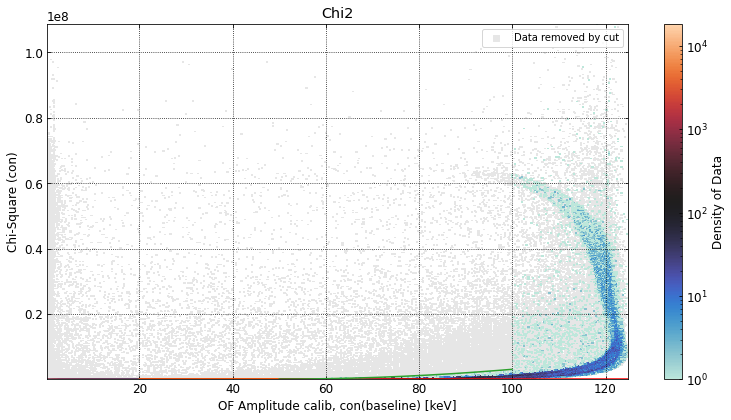

In [34]:
#checking the fit of our amplitudes v chi2
#a "good" fit against chi2 will be about ~ number of bins
fig, ax = dp.densityplot(
    calibratedofamp_constrained,
    df.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger&cgoodtime&cbaseline&cchi2_temp,
    #ylims=[2e4, 5e6],
    #xlims=[0, 120],
    plot_cut_data = True,
    basecut = ctrigger,
)

ax.set_title('Chi2')
ax.set_ylabel(r'Chi-Square (con)')
ax.set_xlabel(r'OF Amplitude calib, con(baseline) [keV]')
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k', zorder=10)

ax.axhline((fs*tracelength),c='r')
#ax.axvline(30, c='blue')
#ax.axvline(80, c='orange')

ax.plot(x_fitting_strictcalb, y_strict_parabcalib)
ax.plot(x_loose_fittingcalib,y_loose_parabcalib)
ax.plot(x_loose_fittingcalib2,y_loose_parabcalib2)

fig.tight_layout()
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/.png',
    dpi=500,
    facecolor='none',
)
#''';

In [32]:
conetwentyup = dp.inrange(calibratedofamp_constrained,100,np.inf)
#csixty_110 = dp.inrange(calibratedofamp_constrained,60,110)
cchi2_strict = (((df.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_constrained,
                                                             m_strict, b_strict)))&
            dp.inrange(calibratedofamp_constrained,-np.inf,20))
cchi2_strict2 = (((df.ofchi2_constrained_CPDv21Ge < temp_func3(calibratedofamp_constrained,
                                                             m_loose, b_loose)))&
            dp.inrange(calibratedofamp_constrained,20,50))
cchi2_strict3 = (((df.ofchi2_constrained_CPDv21Ge < temp_func2(calibratedofamp_constrained,
                                                             m_loose2, b_loose2)))&
            dp.inrange(calibratedofamp_constrained,50,100))
cchi2_temp = ((cchi2_strict | cchi2_strict2 | cchi2_strict3) | conetwentyup)


In [160]:
binsize=5 #sort of flat of amp distribution by each 3 kev
binnumber=110/binsize #only doing this up to 110 kev (where our fold back occurs)

cchi2_percent_list=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    cofamp_temp = dp.inrange(calibratedofamp_constrained,
                             (binsize*i),(binsize*(i+1)))
    cut_value=find_x_percentile(df.ofchi2_constrained_CPDv21Ge[cofamp_temp],96)
    cchi2_percent_list[i]=dp.inrange(df.ofchi2_constrained_CPDv21Ge,-np.inf,cut_value)&cofamp_temp


In [161]:
#percentile chi2
cchi2=cchi2_percent_list[0]
for i in range(len(cchi2_percent_list)):
    cchi2=cchi2|cchi2_percent_list[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut

In [12]:
# trying to do a binned chi2 to cut out the 99th percentile
def find_x_percentile(var, x):
    """
    Parameters:
    -----------
        var: np.array, array of 1D variable who you want to find the Xth percentile of
        x: float, percentile you want to find
        
    Returns:
    --------
    Value of var where you reach the Xth percentile (float)
    
    """
    
    freqs, var_edges = np.histogram(var, 760) #feel free to change from 100 based on number of datapoints, maybe sqrt(N)?
    
    i99 = np.where((np.cumsum(freqs) / np.sum(freqs)) > (x / 100))
    
    try:
        cutoff = i99[0][0]
    except IndexError:
        print('No datapoints within that percentile!')
        return None
    return var_edges[cutoff]

# Checking template fit to pulse shape

## Set up getrandevents

In [110]:
#pulling random traces from 20-30kev
ctwenty_thirtykev_uncon = dp.inrange(calibratedofamp_uncon,20,30)
ctwenty_thirtykev_con = dp.inrange(calibratedofamp_constrained,20,30)

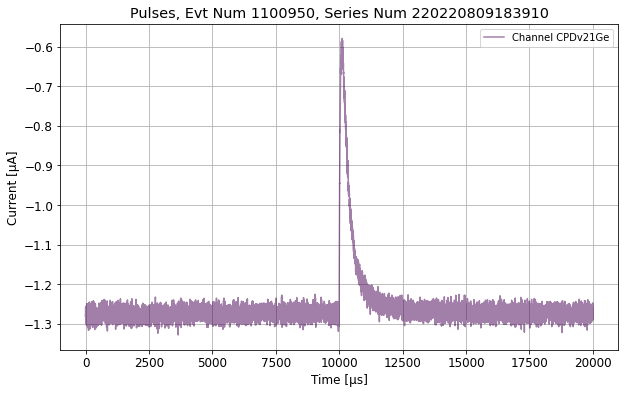

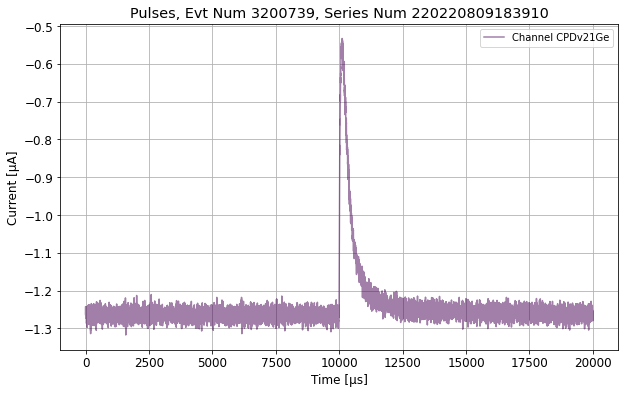

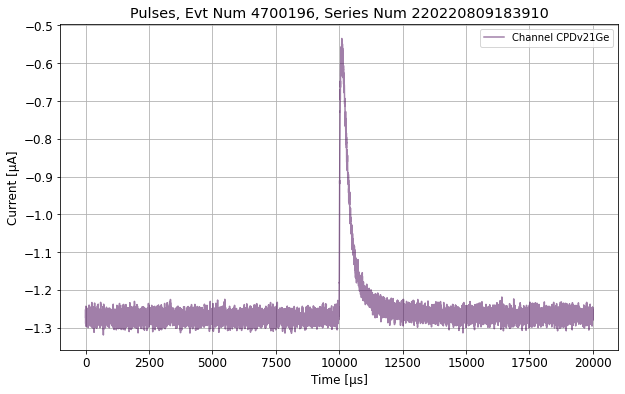

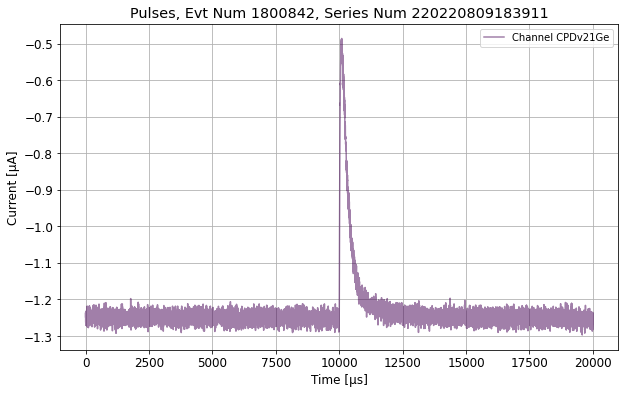

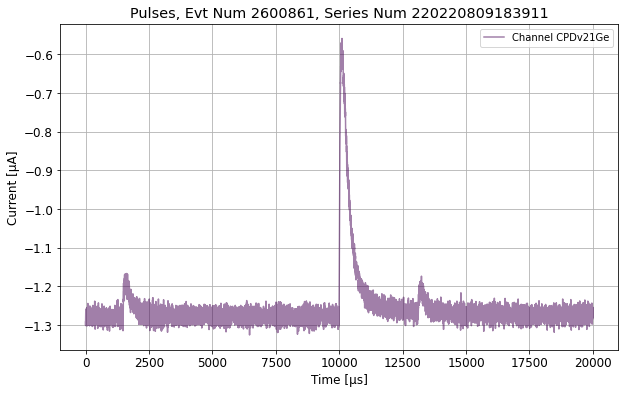

In [128]:
#grabbing 60-120 traces
rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,                    
    ntraces=100,
    nplot=5,
    channels=['CPDv21Ge'],
    cut=cbaseline&ctemp_splitpop,
    lgcplot=True)

In [129]:
#grabbing the x,t,cut
t = rands[0]
x = rands[1]
cout = rands[2]
lowpassed = qp.utils.lowpassfilter(x)

Text(0.5, 1.0, 'lpf pulses (low energy population)')

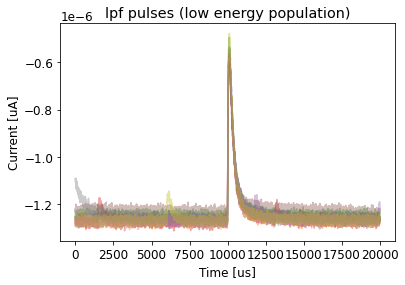

In [136]:

for xx in lowpassed[1:10,0]:
    plt.plot(t*1e6, xx, alpha=0.4)
# plt.plot(t1*1e6, lowpassed_lower[5,0])
#plt.xlim(9500, 12500)
plt.xlabel('Time [us]')
plt.ylabel('Current [uA]')
plt.title('lpf pulses (low energy population)')

NameError: name 'template' is not defined

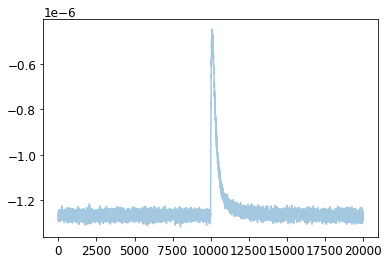

In [117]:
#plotting the template used to process vs the lower distribution trace
trace_number=1
for i in range(trace_number):
    plt.plot(t*1e6, x[i,0], alpha=0.4)
    templaterolled = np.roll(template,int(
        df.oft0_constrained_CPDv21Ge[cout].iloc[i]*fs))
    plt.plot(t*1e6, (templaterolled*
                     df.ofamp_constrained_CPDv21Ge[cout].iloc[i])+
             df.baseline_CPDv21Ge[cout].iloc[i])
plt.xlabel('Time [us]')
plt.ylabel('Current [uA]')
plt.title('pulses and their template (20-30kev)')


## Checking to see if the calibrated ofamp and the calibrated energy have a linear relationship
A linear relationship between the two implies that they are calibrated well. 

Text(0, 0.5, 'calibrated energy abs')

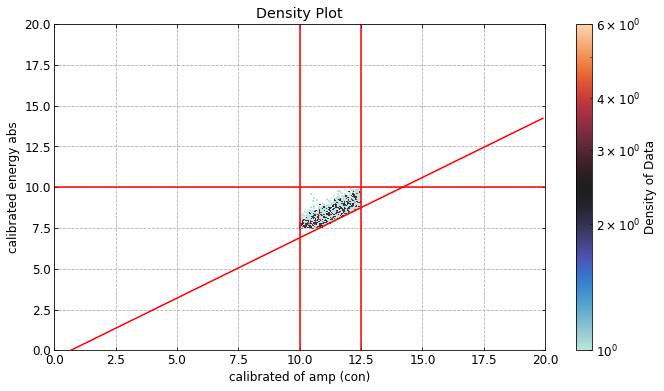

In [127]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_constrained,
    calibratedenergy,
    cut= ctrigger&cbaseline&ctemp_splitpop,
    xlims=(0,20),
    ylims=(0,20)
   # ylims=(-3.25,-2)
    )
ax.plot(x_fitting_strictcalb, y_strict_lin, color='red')
ax.axvline(10, color='red')
ax.axvline(12.5, color = 'red')
ax.axhline(10, color='red')
#ax.axline((1,1), xy2=(20,12.4), color = 'red')
ax.set_xlabel('calibrated of amp (con)')
ax.set_ylabel('calibrated energy abs')

In [109]:
y_strict_lin = b_splitpop+m_splitpop*x_fitting_strictcalb
x_fitting_strictcalb = np.arange(0,20,0.1)
temp_funclin = lambda x, m, b: m * x + b


In [126]:
m_splitpop = 0.74
b_splitpop = -0.5

ctemp_splitpop = (((calibratedenergy > temp_funclin(calibratedofamp_constrained,
                                                             m_splitpop, b_splitpop)))&
            dp.inrange(calibratedofamp_constrained,10,12.5) & dp.inrange(calibratedenergy, 7.5, 10))
            

In [258]:
ctemp_weirdpop = dp.inrange(calibratedofamp_constrained,0,0.48)&dp.inrange(calibratedenergy,0.28,0.75)
c_sqglitch = np.invert(ctemp_weirdpop)

# Combined cuts

## Calibrated OFAmp

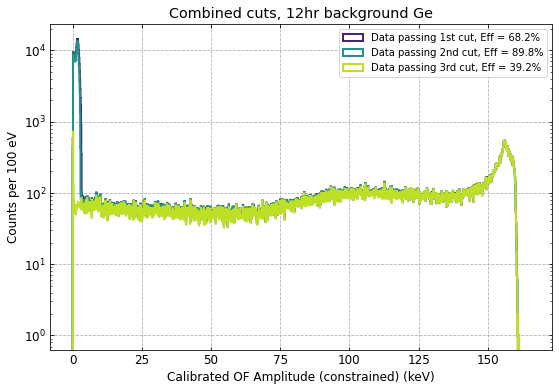

In [447]:

fig, ax = dp.hist(
    calibratedofamp_constrained,
    xlims = (0,165),
    nbins = 1650,
    cuts = [ctrigger&cgoodtime,cbaseline,cchi2_temp&c_sqglitch],
    labeldict = {'title' : 'Combined cuts, 12hr background Ge',
                'xlabel' : 'Calibrated OF Amplitude (constrained) (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/combcuts_nos_12hr_calibofamp_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

## Calibrated energy absorbed

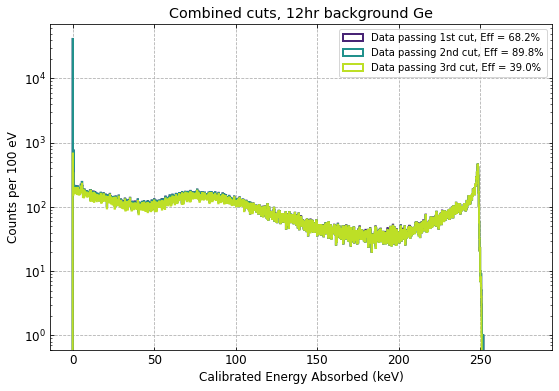

In [388]:

fig, ax = dp.hist(
    calibratedenergy,
    xlims = (0,280),
    nbins = 1700,
    cuts = [ctrigger&cgoodtime,cbaseline,cchi2_temp&c_sqglitch],
    labeldict = {'title' : 'Combined cuts, 12hr background Ge',
                'xlabel' : 'Calibrated Energy Absorbed (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/combcuts_nos_12hr_energabs_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

## Checking true efficiencies in various ranges for comparison between runs

In [389]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp&c_sqglitch
czerosevenkev=dp.inrange(calibratedofamp_constrained,0,7)
cseven60kev=dp.inrange(calibratedofamp_constrained,7,60)
csixtyonetwntykev = dp.inrange(calibratedofamp_constrained,60,120)
conetwntyupkev = dp.inrange(calibratedofamp_constrained,120,np.inf)
callev = dp.inrange(calibratedofamp_constrained, 0,np.inf)

In [443]:
#cutting efficiency tables for 240 us template cuts
#cbaselinelow,cpresat_low_uncon,ctemplow_strict,cdel_low
#ctemp_low = 
cut_list = [cgoodtime,cbaseline,c_sqglitch,cchi2_temp]
index_list = ['time','baseline','chi2glitch','chi2']
energy_list = [czerosevenkev,cseven60kev,csixtyonetwntykev,conetwntyupkev,callev]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_constrained,energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.753600,0.7536,0.664135,0.664135,0.755615,0.755615,0.751814,0.751814,0.754311,0.754311,0.693041,0.693041
baseline,0.984342,0.7418,0.846490,0.562183,0.994830,0.751709,0.994673,0.747809,0.993398,0.749331,0.898321,0.622573
chi2glitch,0.999730,0.7416,0.995485,0.559645,1.000000,0.751709,1.000000,0.747809,1.000000,0.749331,0.997239,0.620854
chi2,0.890642,0.6605,0.023749,0.013291,0.949659,0.713867,0.967162,0.723253,1.000000,0.749331,0.395074,0.245283


In [444]:
ctemp_mask = cbaseline&cchi2_temp&c_sqglitch

In [445]:
randoms_total_eff = 0.66
calc_rate_all = sum(cgoodtime&ctrigger&ctemp_mask)/tot_runtime
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime&ctrigger&ctemp_mask&czerosevenkev)/tot_runtime
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime&ctrigger&ctemp_mask&cseven60kev)/tot_runtime
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime&ctrigger&ctemp_mask&csixtyonetwntykev)/tot_runtime
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime&ctrigger&ctemp_mask&conetwntyupkev)/tot_runtime
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [446]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.11918472820948055, the true rate is 0.18058292152951597

The calculated rate from 7-60 keV is 0.6735526580682666, the true rate is 1.0205343304064645

The calculated rate from 60-120 keV is 1.1065475046383488, the true rate is 1.6765871282399223

The calculated rate from 120-inf keV is 1.3482801172843266, the true rate is 2.04284866255201

The calculated rate from 0-inf keV is 3.2475650082004224, the true rate is 4.920553042727913



# dR/dE rate plots (240 us)

In [398]:
import darklim

/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/maggie_reed/.local/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


<>:20: DeprecationWarning: invalid escape sequence \p
<>:20: DeprecationWarning: invalid escape sequence \p
<>:20: DeprecationWarning: invalid escape sequence \p
<ipython-input-425-94b2eed557aa>:20: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


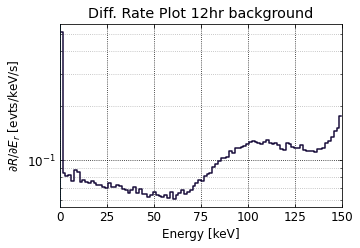

In [425]:
##cmask_240f = cgoodtime_both&cbaselinelow&ctemplow_strict&cdel_low&cpresat_low_uncon
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedofamp_constrained[ctrigger&ctemp_mask],
    1 * tot_runtime,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr background")
ax.axvline(0.3)

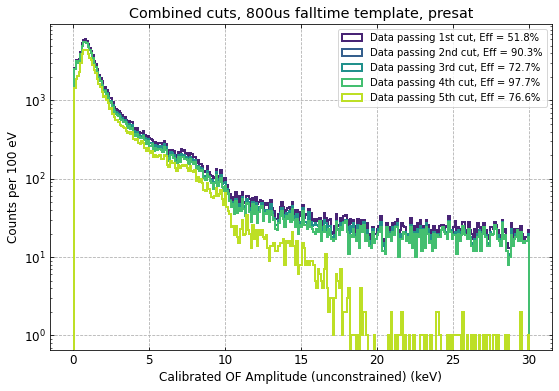

In [288]:
#Combined cuts, rates, 800 us falltime, presaturation only
#cmask_800f = cgoodtime_both&cbaselineup&ctempup_loose&cdel_up&cpresat_up_uncon

fig, ax = dp.hist(
    calibratedofamp_up,
    xlims = (0,30),
    nbins = 300,
    cuts = [ctrigger_both&cgoodtime_both,cbaselineup,cpresat_up_uncon,ctempup_loose,cdel_up],
    labeldict = {'title' : 'Combined cuts, 800us falltime template, presat',
                'xlabel' : 'Calibrated OF Amplitude (unconstrained) (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_18/figs/800f_combcuts_presat_calibofamp_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-312-95033e2d3d63>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Diff. Rate Plot 800us template presat')

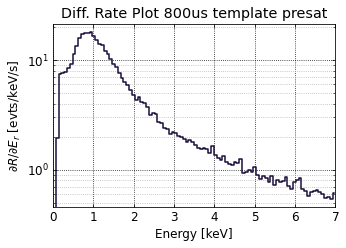

In [312]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 7),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedofamp_up[ctrigger_both&cmask_800f],
    1 * tot_runtime_both,
    efficiency=randoms_total_eff_up,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 800us template presat")

# Other

In [22]:
#this creates a chi squared cut to use on randoms, that selects data with chi squared within 3 standard deviations of the mean
#in a chi squared distribution, the mean is the number of degrees of freedom and the variance is twice that
#the st dev is the square root of the variance
samplerate=fs
chi_thresh= int(tracelength*samplerate) + 3 * np.sqrt(2 * int(tracelength*samplerate))
chi_thresh_lower= int(tracelength*samplerate) - 3 * np.sqrt(2 * int(tracelength*samplerate))
crandschisqared = ((df.ofchi2_nodelay_CPDv21Ge < chi_thresh) & (df.ofchi2_nodelay_CPDv21Ge > chi_thresh_lower))

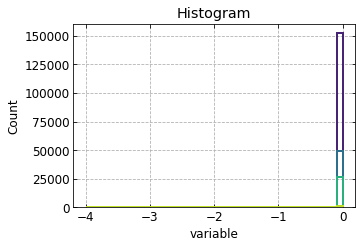

In [136]:

fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
   df.baseline_CPDv21Ge,
    xlims=(-4,-0),
#    ylims=(),
    ax=ax,
    nbins=50,
#     cmap='binary_r',
    cuts=[ctrigger&cgood_time,ctemp_up,ctemp_loose,ctemp_tenfifteenkev],
    lgcrawdata=False,
    lgclegend=False,
)
ax.set_yscale('linear')


39.82751844259718

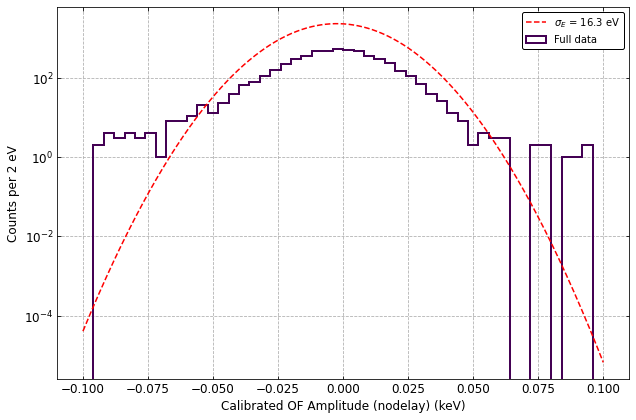

In [50]:
fig, ax = dp.hist(
    calibratedofamp_nodelay[crandoms&crandschisqared],
    nbins=50,
    xlims=(-0.1,0.1),
    labeldict = {'title' : None,
                'xlabel' : 'Calibrated OF Amplitude (nodelay) (keV)',
                'ylabel' : 'Counts per 2 eV',
                },
)
x_mean, x_std, _ = qp.cut.iterstat(calibratedofamp_nodelay[crandoms&crandschisqared])

xx = np.linspace(-0.10, 0.10, num=1000)

hist, bin_edges = np.histogram(calibratedofamp_nodelay, bins=50, range=(-.10, .10))
norm = hist.sum() * np.mean(np.diff(bin_edges))

yy = stats.norm.pdf(xx, scale=x_std, loc=x_mean) * norm

ax.plot(
    xx,
    yy,
    color='r',
    linestyle='dashed',
    label=r'$\sigma_E$' + f' = {x_std*1000:.1f} eV'
)

ax.legend(loc='upper right', framealpha=1, edgecolor='k')
fig.tight_layout()

np.std(calibratedofamp_nodelay)
#standard deviation of noise in calibrated OF amp, this is the baseline energy resolution
#we expect probably better than 20 eV



# Cut efficiencies function

In [391]:
def cutefficiencies(cut_array,cut_index, suffix, energy_cut_array=None,columns=None,basecut=None,energy_ranges=None):
    calibratedofamp = suffix
    if basecut == None:
        basecut=dp.inrange(calibratedofamp,-np.inf,np.inf)
    
    if columns == None:
        columns=['Randoms - Differential Efficiency','Randoms - Total Efficiency']
        if energy_cut_array == None:
            columns.append('Trigger - Differential Efficiency')
            columns.append('Trigger - Total Efficiency')
        else:
            if energy_ranges == None:
                for count, energycut in enumerate(energy_cut_array):
                    columns.append(f'Trigger - Differential Efficiency - range {count+1}')
                    columns.append(f'Trigger - Total Efficiency - range {count+1}')
            else: 
                if len(energy_cut_array) != len(energy_ranges):
                    return "Error - energy_range and energy_cut_array length do not match"
                else:
                    for count, e_range in enumerate(energy_ranges):
                        columns.append(f'Trigger ({e_range})- Differential Efficiency')
                        columns.append(f'Trigger ({e_range})- Total Efficiency')
    
    eff_array=[]
    
    for count, cut in enumerate(cut_array):
        cut_random_diff=sum(cut&basecut&crandoms)/sum(crandoms&basecut)
        cut_random_tot=sum(cut&basecut&crandoms)/sum(crandoms)
        cut_ind=[cut_random_diff,cut_random_tot]
        if energy_cut_array == None:
            cut_trigger_diff=sum(cut&basecut&ctrigger)/sum(ctrigger&basecut)
            cut_trigger_tot=sum(cut&basecut&ctrigger)/sum(ctrigger)
            cut_ind.append(cut_trigger_diff)
            cut_ind.append(cut_trigger_tot)
        else:
            for n, energycut in enumerate(energy_cut_array):
                cut_trigger_diff=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&basecut&energycut)
                cut_trigger_tot=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&energycut)
                cut_ind.append(cut_trigger_diff)
                cut_ind.append(cut_trigger_tot)
        eff_array.append(cut_ind)
        basecut=basecut&cut
    cut_table=pd.DataFrame(eff_array,
                           columns=columns,
                           index=cut_index)
    return cut_table.head()

In [66]:
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
bins=100
_, ax = dp.hist(
   calibratedofamp,
 #   xlims=(0, 2),
    ax=ax,
    nbins=100,
#     cmap='binary_r',
    cuts=[ctrigger, cgood_time, cbaseline1, ctemp_loose],
    lgcrawdata=False,
    labeldict = {'title' : 'Efficiencies, loose chi2',
                'xlabel' : 'Calibrated OF Amplitude (uncon) (keV)',
                'ylabel' : (f'Counts per {int((bins[1] - bins[0]) / nbins)} eV')
                 
                 

SyntaxError: invalid syntax (<ipython-input-66-7085f8b92542>, line 14)

In [218]:
#paranoid checking the fall time of the presat fit pos delchi2
#averaging and time shifting lower
x_temp_low = np.zeros(posdelchi2_x.shape)
for ii in range(posdelchi2_x.shape[0]):
    ts = np.roll(posdelchi2_x[ii,0],-int(df_both.oft0_constrained_CPDv21Ge_up[cout_posdelchi2].iloc[ii]*fs))
    ts-= np.mean(ts[0:6000])
    x_temp_low[ii] = ts/ts.max()

x_avg_low = np.mean(x_temp_low, axis = 0) 

Text(0.5, 1.0, 'posdelchi2 presat 1000 averaged normalized traces')

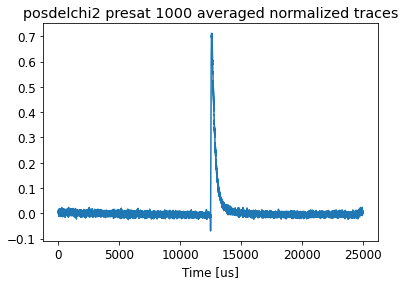

In [219]:
plt.plot(x_avg_low[0])
plt.xlabel('Time [us]')
#plt.ylabel('Current [uA]')
plt.title('posdelchi2 presat 1000 averaged normalized traces')

In [220]:
with open(yaml_path) as f:
    yaml_dict = yaml.load(f)
NLIN = (qp.OFnonlin(np.loadtxt
                (yaml_dict['CPDv21Ge']
                ['psd_path']) * 1e-20, 1.25e6)
       )

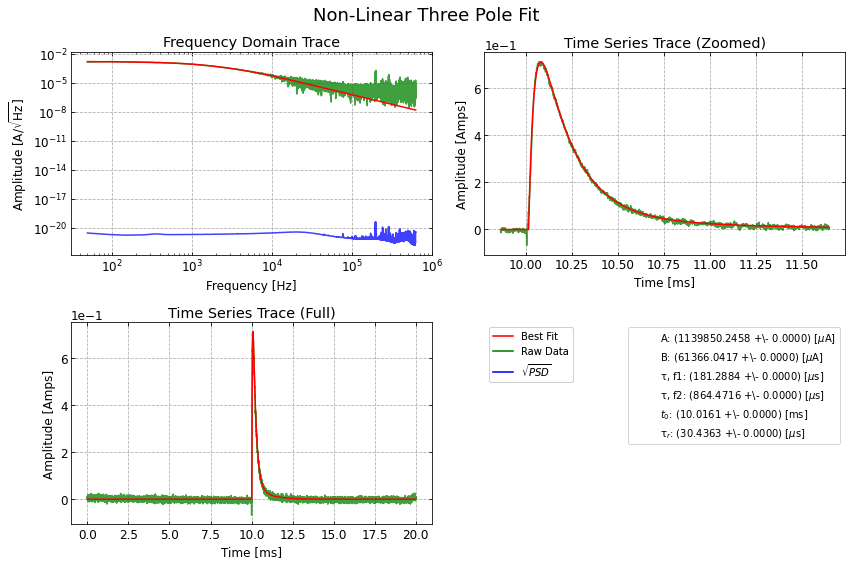

In [222]:
#three pole fit for template of the lower cuts

#returns amplitude or pulse height, rise time, fall time, time offset 
low_gooda, low_goodb, low_goodrise, low_goodf1, low_goodf2, low_tao = (NLIN.fit_falltimes(
    x_avg_low[0], npolefit=3, guess=(1, 0.5, 10e-6, 60e-6, 1000e-6, 10e-3), lgcplot=True))